In [1]:
import sys
import pandas as pd
import numpy as np
import gzip
import folium
import math
import seaborn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN 

In [2]:
# Setting the seaborn and can use matplot with no code change but produce prettier graph 
seaborn.set()

#importing cleaned data (is the 'output.csv' result from cleaning_data.ipynb)
data = pd.read_csv("output.csv")

#filtering for only downtown vancouver data
van_data = data[(data['lat'] >= 49.2762) & (data['lat'] <= 49.2941)]
van_data = van_data[(van_data['lon'] >= -123.1468) & (van_data['lon'] <= -123.0994)]
van_data = van_data.reset_index(drop = True)

#splitting datasets into competitors and attractions where competitors have an amenity type that's in the list competitor_types
competitor_types = ['pub', 'cafe', 'bar', 'restaurant', 'ice_cream', 'fast_food', 'food_court']
van_data['is_comp'] = van_data.apply(lambda x: True if x['amenity'] in competitor_types else False, axis = 1)
van_data

,Unnamed: 0,lat,lon,timestamp,amenity,name,tags,is_comp
0,16,49.283192,-123.109050,2015-12-18T21:41:07.000-08:00,pub,The Cambie,"{'toilets:wheelchair': 'no', 'wheelchair': 'li...",True
1,73,49.281998,-123.124346,2019-03-22T02:51:06.000-07:00,cinema,Scotiabank Theatre Vancouver,"{'addr:housenumber': '900', 'website': 'https:...",False
2,74,49.280504,-123.106872,2019-12-01T04:03:46.000-08:00,theatre,Cineplex Odeon International Village Cinemas,"{'addr:housenumber': '88', 'alt_name': 'Tinsel...",False
3,113,49.277773,-123.120853,2016-08-19T18:55:24.000-07:00,bicycle_rental,Nelson & Richards,"{'ref': '0079', 'capacity': '30', 'network': '...",False
4,187,49.279224,-123.099510,2019-09-02T22:08:26.000-07:00,university,UBC Learning Exchange,"{'addr:housenumber': '612', 'website': 'http:/...",False
...,...,...,...,...,...,...,...,...
921,17541,49.279418,-123.120599,2019-12-08T21:01:09.000-08:00,restaurant,Cibo Trattora,"{'opening_hours:signed': 'no', 'cuisine': 'ita...",True
922,17563,49.285288,-123.139022,2019-08-29T18:01:23.000-07:00,fast_food,McDonald's,"{'brand:wikidata': 'Q38076', 'wheelchair': 'ye...",True
923,17585,49.286882,-123.142093,2019-10-28T15:41:35.000-07:00,restaurant,Milestones,"{'addr:housenumber': '1210', 'website': 'https...",True
924,17632,49.281103,-123.121914,2019-07-16T21:37:02.000-07:00,restaurant,Poke Time,"{'website': 'https://www.poketime.ca', 'openin...",True


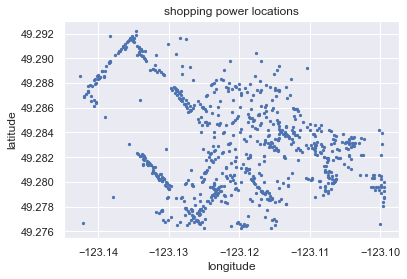

In [3]:
#plotting business amenities in downtown vancouver
shopping_power_types = ['cafe', 'fast_food', 'restaurant', 'pub', 'cinema', 'theatre', 'bar', 'ice_cream', 'university', 'nightclub', 'marketplace', 'spa', 'events_venue', 'food_court', 'juice_bar', 'internet_cafe', 'social_centre', 'shop|clothes', 'leisure']
shopping_power_locations = van_data[van_data['amenity'].isin(shopping_power_types)] #trimmed down to 807 entries

# Plot locations of all filtered shopping power amenity
plt.scatter(shopping_power_locations['lon'].values, shopping_power_locations['lat'].values, s=5)
plt.title('shopping power locations')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()


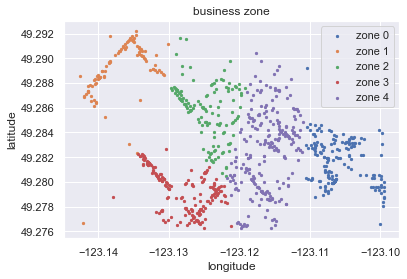

In [4]:
#usingg clustering to determine the 5 business zones in downtown vancouver
# Reference: https://www.askpython.com/python/examples/plot-k-means-clusters-python
#function for plotting
def plot_clustering(model_label): 
    u_labels = np.unique(model_label)

    for i in u_labels:
        cluster = location_points[kmeans_label == i]
        plt.scatter(cluster['lon'], cluster['lat'], label = ("zone " + str(i)), s=5)
    
    plt.title('business zone')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.legend()
    plt.show()
    

#creating model for data
location_points = shopping_power_locations[['lon', 'lat']] 
kmeans_model = KMeans(n_clusters=5)
kmeans_label = kmeans_model.fit_predict(location_points)

# Plot KMeans
plot_clustering(kmeans_label)

In [5]:
#determine points and boundaries for each business zone
boundaries = []
zone_a = location_points[kmeans_label == 0]   #zone 0 in graph above
zone_b = location_points[kmeans_label == 1]   #zone 1 in graph above
zone_c = location_points[kmeans_label == 2]   #zone 2 in graph above
zone_d = location_points[kmeans_label == 3]   #zone 3 in graph above
zone_e = location_points[kmeans_label == 4]   #zone 4 in graph above

zone_a

,lon,lat
0,-123.109050,49.283192
2,-123.106872,49.280504
4,-123.099510,49.279224
5,-123.099839,49.282155
6,-123.100280,49.279605
...,...,...
863,-123.099495,49.279572
864,-123.104170,49.281850
865,-123.104530,49.282647
881,-123.109459,49.283172


In [6]:
# in each zone, we will find 11 locations based off the average lon and lat and percentile increases of lon and lat that 
# create potential locations within the zone
# result is a diagonal line of generated points centered on the average lon/lat for each zone

def find_potential_loc(zone):
    number_loc = len(zone)
    avg_lon = zone['lon'].sum()/number_loc
    avg_lat = zone['lat'].sum()/number_loc
    lon_increment = (zone['lon'].max() - avg_lon)/10
    lat_increment = (zone['lat'].max() - avg_lat)/10
    
  
    #generating potential locations within boundaries of the zone
    res_lat = []
    res_lon = []
    res_lat.append(avg_lat)
    res_lon.append(avg_lon)
    for i in range(5):
        res_lat.append(res_lat[i] + lat_increment)
        res_lon.append(res_lon[i] + lon_increment)
    res_lat.append(avg_lat - lat_increment)
    res_lon.append(avg_lon - lon_increment)
    for i in range(5, 10):
        res_lat.append(res_lat[i] - lat_increment)
        res_lon.append(res_lon[i] - lon_increment)
    
    #creating dataframe for generated locations
    data = {'lat': res_lat, 'lon': res_lon}
    
    res = pd.DataFrame(data, columns = ['lat', 'lon'])
    return res

def plot_for_zones(zone, gen_points):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(gen_points['lon'], gen_points['lat'], label = 'Generated Locations')
    ax.scatter(zone['lon'], zone['lat'], label = 'Business Locations')
    ax.legend()

    plt.title('Business Zone for Zone 1')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    

An example of results for Zone 0
          lat         lon
0   49.281663 -123.105774
1   49.282416 -123.105144
2   49.283169 -123.104515
3   49.283923 -123.103885
4   49.284676 -123.103256
5   49.285429 -123.102626
6   49.280910 -123.106404
7   49.284676 -123.103256
8   49.280156 -123.107033
9   49.283923 -123.103885
10  49.279403 -123.107663
11  49.283169 -123.104515


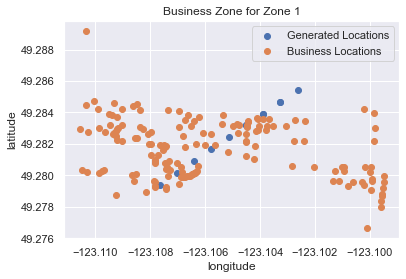

In [8]:
#generating points for all 5 zones
gen_zone_a = find_potential_loc(zone_a)
gen_zone_b = find_potential_loc(zone_b)
gen_zone_c = find_potential_loc(zone_c)
gen_zone_d = find_potential_loc(zone_d)
gen_zone_e = find_potential_loc(zone_e)

#this is an example of the results of location generation for zone_a
print("An example of results for Zone 0")
print(gen_zone_a)
plot_for_zones(zone_a, gen_zone_a)

In [9]:
#using the haversine equation from exercises,
#original source: https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula/21623206
def distance(s_lat, s_lon, l_lat, l_lon):
    p = 0.017453292519943295;         # Math.PI / 180

    latdiff = s_lat - l_lat
    londiff = s_lon - l_lon

    a = 0.5 - np.cos((latdiff) * p)/2 + np.cos(s_lat * p) * np.cos(l_lat * p) * (1 - np.cos((londiff) * p))/2
    return 12742 * np.arcsin(np.sqrt(a))

#to determine attractiveness score, we use a formula 
#each amenity location has an attractiveness score that ranges from [0, 1] 
#a score of 1 implies amenity at same location as chosen_location and a score of 0 implies amenity is the furthest amenity
#from chosen_location

#score is dependent on the impact where impact is based off of the distance of amenity relative of farthest amenity to chosen_location
#therefore attractiveness score = 1 * impact
#impact = 1 - [(amenity distance)/(farthest amenity distance)]

def det_attract(dist, max_dist, is_comp):
    score = 1
    if is_comp:
        score = -1
    impact = 1 - (dist/max_dist)
    if impact == 0:
        impact = 0.1
    return score * impact

def get_attract_scores(zone, temp_data):
    scores = []
    for index, row in gen_zone_a.iterrows():
        temp_data['distance'] = temp_data.apply(lambda x: distance(row['lat'], row['lon'], x['lat'], x['lon']), axis = 1)
        max_distance = temp_data['distance'].max()

        #retrieving 10 closest attractions and 10 closest competitors
        comp_data = temp_data[temp_data['is_comp']].sort_values('distance').head(10)
        attract_data = temp_data[temp_data['is_comp'] == False].sort_values('distance').head(10)
        all_data = pd.concat([comp_data, attract_data])

        #determining attractiveness score for each amenity
        all_data['attract_score'] = all_data.apply(lambda x: det_attract(x['distance'], max_distance, x['is_comp']), axis = 1)

        #the cumlative score from all attractions and competitors
        score = all_data['attract_score'].sum()
        #using formula to determine attractiveness score
        location_score = round((10 + score)/20 * 100, 4)
        scores.append(location_score)
    return scores

In [10]:
#generating attraction scores for all zones
zones = [gen_zone_a, gen_zone_b, gen_zone_c, gen_zone_d, gen_zone_e]
temp_data = van_data.copy()
zone_counter = 1
    
for i in zones:
    i['attract_scores'] = get_attract_scores(i, temp_data)
    i['zone'] = zone_counter                                  #using this to keep track of which zone data belongs to
    zone_counter += 1

#showing an example of results
print("zone a results: ")
gen_zone_a

zone a results: 


,lat,lon,attract_scores,zone
0,49.281663,-123.105774,48.9148,1
1,49.282416,-123.105144,48.0909,1
2,49.283169,-123.104515,46.4276,1
3,49.283923,-123.103885,46.1256,1
4,49.284676,-123.103256,46.5151,1
5,49.285429,-123.102626,46.8176,1
6,49.280910,-123.106404,49.2463,1
7,49.284676,-123.103256,46.5151,1
8,49.280156,-123.107033,48.3808,1
9,49.283923,-123.103885,46.1256,1


In [11]:
#finding top 20 potential spots via their attractiveness scores
#merging data for all zones
all_zones = pd.concat(zones).drop_duplicates()
all_zones = all_zones.sort_values('attract_scores', ascending = False).head(20)
all_zones = all_zones.reset_index(drop = True)

#top 20 potential spots
all_zones

,lat,lon,attract_scores,zone
0,49.285170,-123.125158,49.2463,3
1,49.281724,-123.116692,49.2463,5
2,49.288848,-123.137526,49.2463,2
3,49.280910,-123.106404,49.2463,1
4,49.278944,-123.128594,49.2463,4
5,49.289156,-123.136857,48.9148,2
6,49.285755,-123.124611,48.9148,3
7,49.279283,-123.127923,48.9148,4
8,49.281663,-123.105774,48.9148,1
9,49.282516,-123.116174,48.9148,5


In [12]:
#plotting top 5 potential spots on a map (from mapping_data)
#plotting results on map, use different marker plotting function, red for competitors, green for attractions
def place_coloured_marker(the_map, lat, long, name, is_comp):
    chosen_colour = 'green'
    if is_comp:
        chosen_colour = 'red'
    spot = [lat, long]
    marker = folium.Marker(location=[lat, long], popup = str(spot), icon=folium.Icon(color = chosen_colour), tooltip = name)
    marker.add_to(the_map)

#place a default marker for chosen location (marker colour is blue)
def place_marker(the_map, lat, long, name):    
    spot = [lat, long]
    marker = folium.Marker(location=[lat, long], popup = str(spot), tooltip = name)
    marker.add_to(the_map)

#find locations used for chosen location's attractiveness score
def find_locations(data, loc_lon, loc_lat):
    data['distance'] = data.apply(lambda x: distance(loc_lat, loc_lon, x['lat'], x['lon']), axis = 1)
    max_distance = temp_data['distance'].max()
    
    comp_data = temp_data[temp_data['is_comp']].sort_values('distance').head(10)
    attract_data = temp_data[temp_data['is_comp'] == False].sort_values('distance').head(10)
    return attract_data, comp_data

#plot results on map
def plot_on_map(temp_data, loc_lon, loc_lat, curr_map):
    #get locations
    attract_data, comp_data = find_locations(temp_data, loc_lon, loc_lat)
    
    #plot locations
    comp_data.apply(lambda x: place_coloured_marker(curr_map, x['lat'], x['lon'], x['name'], x['is_comp']), axis = 1)
    attract_data.apply(lambda x: place_coloured_marker(curr_map, x['lat'], x['lon'], x['name'], x['is_comp']), axis = 1)
    
    #fitting map dimensions
    all_data = pd.concat([attract_data, comp_data])
    min_corner = all_data[['lat', 'lon']].min().values.tolist()
    max_corner = all_data[['lat', 'lon']].max().values.tolist()
    curr_map.fit_bounds([min_corner, max_corner]) 

# zone_dic = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

In [13]:
# #plotting 1st result
print("These are the 1st highest result. \n Zone: ", all_zones.loc[0]['zone'],
      "\n Attractiveness Score: ", all_zones.loc[0]['attract_scores'])
lat = all_zones.loc[0]['lat']
lon = all_zones.loc[0]['lon']

curr_map = folium.Map(location=[lat, lon], zoom_start = 12)
place_marker(curr_map, lat, lon, 'Chosen Location')
plot_on_map(temp_data, lon, lat, curr_map)
curr_map


These are the 1st highest result. 
 Zone:  3.0 
 Attractiveness Score:  49.2463


In [17]:
# #plotting 2nd result
print("These are the 2nd highest result. \n Zone: ", all_zones.loc[1]['zone'],
      "\n Attractiveness Score: ", all_zones.loc[1]['attract_scores'])
lat = all_zones.loc[1]['lat']
lon = all_zones.loc[1]['lon']

curr_map = folium.Map(location=[lat, lon], zoom_start = 12)
place_marker(curr_map, lat, lon, 'Chosen Location')
plot_on_map(temp_data, lon, lat, curr_map)
curr_map

These are the 2nd highest result. 
 Zone:  5.0 
 Attractiveness Score:  49.2463


In [18]:
# #plotting 3rd result
print("These are the 3rd highest result. \n Zone: ", all_zones.loc[2]['zone'],
      "\n Attractiveness Score: ", all_zones.loc[2]['attract_scores'])
lat = all_zones.loc[2]['lat']
lon = all_zones.loc[2]['lon']

curr_map = folium.Map(location=[lat, lon], zoom_start = 12)
place_marker(curr_map, lat, lon, 'Chosen Location')
plot_on_map(temp_data, lon, lat, curr_map)
curr_map

These are the 3rd highest result. 
 Zone:  2.0 
 Attractiveness Score:  49.2463


In [19]:
# #plotting 4th result
print("These are the 1st highest result. \n Zone: ", all_zones.loc[3]['zone'],
      "\n Attractiveness Score: ", all_zones.loc[3]['attract_scores'])
lat = all_zones.loc[3]['lat']
lon = all_zones.loc[3]['lon']

curr_map = folium.Map(location=[lat, lon], zoom_start = 12)
place_marker(curr_map, lat, lon, 'Chosen Location')
plot_on_map(temp_data, lon, lat, curr_map)
curr_map

These are the 1st highest result. 
 Zone:  1.0 
 Attractiveness Score:  49.2463


In [21]:
# #plotting 5th result
print("These are the 1st highest result. \n Zone: ", all_zones.loc[4]['zone'],
      "\n Attractiveness Score: ", all_zones.loc[4]['attract_scores'])
lat = all_zones.loc[4]['lat']
lon = all_zones.loc[4]['lon']

curr_map = folium.Map(location=[lat, lon], zoom_start = 12)
place_marker(curr_map, lat, lon, 'Chosen Location')
plot_on_map(temp_data, lon, lat, curr_map)
curr_map

These are the 1st highest result. 
 Zone:  4.0 
 Attractiveness Score:  49.2463
